In [268]:
from imgaug import augmenters as iaa
from keras.preprocessing.image import ImageDataGenerator, DirectoryIterator, load_img, img_to_array, array_to_img
import imgaug as ia
import numpy as np
import pandas as pd
from pandas import DataFrame
from tqdm import tqdm
import time
import os
import cv2
import shutil
import matplotlib.pyplot as plt
%matplotlib inline

创建用于存放数据增强后图片的目录

In [272]:
def rmrf_mkdir(dirname):
    if os.path.exists(dirname):
        shutil.rmtree(dirname)
    os.mkdir(dirname)
    
train_dir = "data/imgs/train"
train_aug_dir = "data/imgs/train_aug"

rmrf_mkdir(train_aug_dir)

加载需要做数据增强的数据表

In [6]:
drivers_pd = pd.read_csv("data/driver_imgs_list.csv")

In [11]:
sometimes = lambda aug: iaa.Sometimes(0.5, aug)
seq = iaa.Sequential(
    [
        # apply the following augmenters to most images
        iaa.Fliplr(0.5) # horizontally flip 50% of all images
#         iaa.Flipud(0.2), # vertically flip 20% of all images
#         # crop images by -5% to 10% of their height/width
#         sometimes(iaa.CropAndPad(
#             percent=(-0.05, 0.1),
#             pad_mode=ia.ALL,
#             pad_cval=(0, 255)
#         )),
#         sometimes(iaa.Affine(
#             scale={"x": (0.8, 1.2), "y": (0.8, 1.2)}, # scale images to 80-120% of their size, individually per axis
#             translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)}, # translate by -20 to +20 percent (per axis)
#             rotate=(-45, 45), # rotate by -45 to +45 degrees
#             shear=(-16, 16), # shear by -16 to +16 degrees
#             order=[0, 1], # use nearest neighbour or bilinear interpolation (fast)
#             cval=(0, 255), # if mode is constant, use a cval between 0 and 255
#             mode=ia.ALL # use any of scikit-image's warping modes (see 2nd image from the top for examples)
#         )),
#         # execute 0 to 5 of the following (less important) augmenters per image
#         # don't execute all of them, as that would often be way too strong
#         iaa.SomeOf((0, 5),
#                    [
#                        sometimes(iaa.Superpixels(p_replace=(0, 1.0), n_segments=(20, 200))), # convert images into their superpixel representation
#                        iaa.OneOf([
#                            iaa.GaussianBlur((0, 3.0)), # blur images with a sigma between 0 and 3.0
#                            iaa.AverageBlur(k=(2, 7)), # blur image using local means with kernel sizes between 2 and 7
#                            iaa.MedianBlur(k=(3, 11)), # blur image using local medians with kernel sizes between 2 and 7
#                        ]),
#                        iaa.Sharpen(alpha=(0, 1.0), lightness=(0.75, 1.5)), # sharpen images
#                        iaa.Emboss(alpha=(0, 1.0), strength=(0, 2.0)), # emboss images
#                        # search either for all edges or for directed edges,
#                        # blend the result with the original image using a blobby mask
#                        iaa.SimplexNoiseAlpha(iaa.OneOf([
#                            iaa.EdgeDetect(alpha=(0.5, 1.0)),
#                            iaa.DirectedEdgeDetect(alpha=(0.5, 1.0), direction=(0.0, 1.0)),
#                        ])),
#                        iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.5), # add gaussian noise to images
#                        iaa.OneOf([
#                            iaa.Dropout((0.01, 0.1), per_channel=0.5), # randomly remove up to 10% of the pixels
#                            iaa.CoarseDropout((0.03, 0.15), size_percent=(0.02, 0.05), per_channel=0.2),
#                        ]),
#                        iaa.Invert(0.05, per_channel=True), # invert color channels
#                        iaa.Add((-10, 10), per_channel=0.5), # change brightness of images (by -10 to 10 of original value)
#                        iaa.AddToHueAndSaturation((-20, 20)), # change hue and saturation
#                        # either change the brightness of the whole image (sometimes
#                        # per channel) or change the brightness of subareas
#                        iaa.OneOf([
#                            iaa.Multiply((0.5, 1.5), per_channel=0.5),
#                            iaa.FrequencyNoiseAlpha(
#                                exponent=(-4, 0),
#                                first=iaa.Multiply((0.5, 1.5), per_channel=True),
#                                second=iaa.ContrastNormalization((0.5, 2.0))
#                            )
#                        ]),
#                        iaa.ContrastNormalization((0.5, 2.0), per_channel=0.5), # improve or worsen the contrast
#                        iaa.Grayscale(alpha=(0.0, 1.0)),
#                        sometimes(iaa.ElasticTransformation(alpha=(0.5, 3.5), sigma=0.25)), # move pixels locally around (with random strengths)
#                        sometimes(iaa.PiecewiseAffine(scale=(0.01, 0.05))), # sometimes move parts of the image around
#                        sometimes(iaa.PerspectiveTransform(scale=(0.01, 0.1)))
#                    ],
#                    random_order=True
#                    )
    ]
#     random_order=True
)

查看需要处理的原始图像

In [30]:
drivers_pd.head()

,subject,classname,img
0,p002,c0,img_44733.jpg
1,p002,c0,img_72999.jpg
2,p002,c0,img_25094.jpg
3,p002,c0,img_69092.jpg
4,p002,c0,img_92629.jpg


查看数据增强处理前的原始图片，这里选取数据表中同一个司机ID的前10张图片，发现几乎完全一样，连肉眼都不能清楚分辨，图片的重复程度非常高

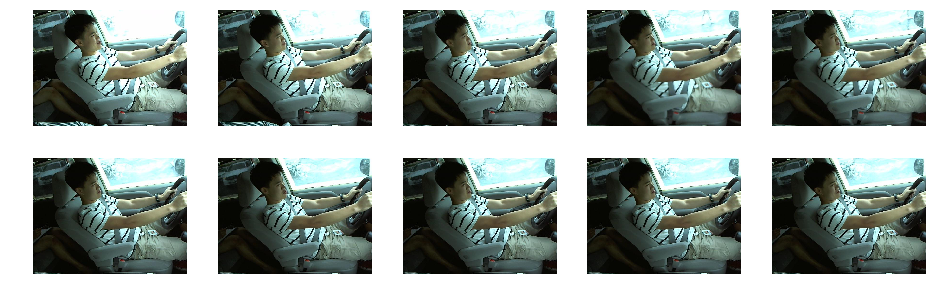

In [74]:
plt.figure(figsize=(16, 5))
for i in range(10):
    plt.subplot(2, 5, i+1)
    
    driver_id = drivers_pd.at[i, 'subject']
    driver_class = drivers_pd.at[i, 'classname']
    driver_img = drivers_pd.at[i, 'img']
    
    img = load_img(train_dir + '/' + driver_class + '/' + driver_img)
    plt.axis('off')
    plt.imshow(img)

左右翻转图像

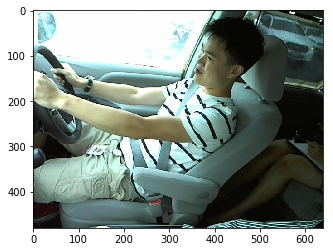

In [176]:
aug = iaa.Fliplr(1)

driver_class = drivers_pd.at[0, 'classname']
driver_img = drivers_pd.at[0, 'img']
img = load_img(train_dir + '/' + driver_class + '/' + driver_img)

x = img_to_array(img)
x = aug.augment_image(x)
img_aug = array_to_img(x)
plt.imshow(img_aug)
plt.show()

截取图片

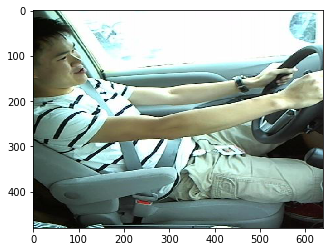

In [177]:
aug = iaa.CropAndPad(percent=(0, 0, 0, -np.random.randint(30, 40) / 100))

driver_class = drivers_pd.at[0, 'classname']
driver_img = drivers_pd.at[0, 'img']
img = load_img(train_dir + '/' + driver_class + '/' + driver_img)

x = img_to_array(img)
x = aug.augment_image(x)
img_aug = array_to_img(x)
plt.imshow(img_aug)
plt.show()

data/imgs/train/c0/img_44733.jpg
data/imgs/train/c0/img_9484.jpg
write to file: data/imgs/train_aug/img_44733_137.jpg


True

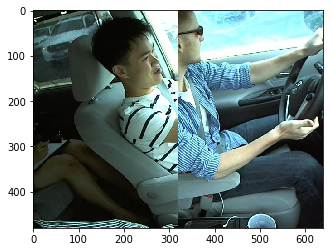

In [285]:
driver_id = drivers_pd.at[0, 'subject']
driver_class = drivers_pd.at[0, 'classname']
driver_img = drivers_pd.at[0, 'img']
path1 = train_dir + '/' + driver_class + '/' + driver_img
print(path1)
img1 = load_img(path1)
img1 = img_to_array(img1)

add_img_name = np.random.choice(drivers_pd.query("classname=='"+driver_class+"' & subject!='"+driver_id+"'")["img"])
path2 = train_dir + '/' + driver_class + '/' + add_img_name
print(path2)
img2 = load_img(path2)
img2 = img_to_array(img2)

left = img1[:, :640//2, :]
right = img2[:, 640//2:, :]
x = np.concatenate((left, right), axis=1)
img = array_to_img(x)
plt.imshow(img)

filename, ext = os.path.splitext(path1)
new_file_name = filename.split("/")[-1] + "_" + str(np.random.randint(0,1000)) + ext
new_path = os.path.join(train_aug_dir, new_file_name)
print("write to file:", new_path)
cv2.imwrite(new_path, x)

In [253]:
drivers_pd = pd.read_csv("data/driver_imgs_list.csv")
imgs_pd = drivers_pd["img"]
class_pd = drivers_pd["classname"]
subject_pd = drivers_pd["subject"]
choices = np.random.choice(drivers_pd["subject"].drop_duplicates(), 2)
print("选择作为验证集的司机ID:", choices)

选择作为验证集的司机ID: ['p002' 'p012']


In [254]:
val_index = []
for choice in choices:
    val_index.extend(subject_pd[subject_pd == choice].index.tolist())
    
test_mask = np.zeros(np.alen(subject_pd), dtype=np.bool)
for val_i in val_index:
    test_mask[val_i] = True
    
train_index = subject_pd[np.logical_not(test_mask)].index
print("分割的训练集数量:", np.alen(train_index), "，验证集数量:", np.alen(val_index))

分割的训练集数量: 20876 ，验证集数量: 1548


In [ ]:
rmrf_mkdir(train_aug_dir)

def cv2_load_img(path):
    img = cv2.imread(path)
    img = np.array(img, dtype=np.float32)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

def merge_img(img1, img2):
    left = img1[:, :320, :]
    right = img2[:, 320:, :]
    img_arr = np.concatenate((left, right), axis=1)
    return img_arr

def save_merge_img(save_dir, filename, img_arr):
    if not os.path.exists(save_dir):
        os.mkdir(save_dir)
    new_path = os.path.join(save_dir, filename)
#     print("write to file:", new_path)
    img_arr = cv2.cvtColor(img_arr, cv2.COLOR_RGB2BGR)
    cv2.imwrite(new_path, img_arr)
    
train_pd = drivers_pd.iloc[train_index]
train_aug_pd = DataFrame({
    "subject":[],
    "classname":[],
    "img":[]
})
aug_img_number = 10
for index in tqdm(train_index):
    id = train_pd.at[index, 'subject']
    cls = train_pd.at[index, 'classname']
    img_name = train_pd.at[index, 'img']
    path1 = train_dir + '/' + cls + '/' + img_name
#     print(path1)
    img1 = cv2_load_img(path1)
    
    for i in range(aug_img_number):
        add_img_name = np.random.choice(train_pd.query("classname=='"+cls+"' & subject!='"+id+"'")["img"])
        path2 = train_dir + '/' + cls + '/' + add_img_name
#         print(path2)
        img2 = cv2_load_img(path2)

        new_img = merge_img(img1, img2)

        filename, ext = os.path.splitext(path1)
        new_file_name = filename.split("/")[-1] + "_" + str(i) + ext
        new_file_dir = os.path.join(train_aug_dir, cls)
        save_merge_img(new_file_dir, new_file_name, new_img)
        
        data = {
            "subject": id,
            "classname": cls,
            "img": new_file_name
        }
        train_aug_pd.append(data, ignore_index=True)
    
    train_aug_pd.to_csv("data/train_aug_checkpoint.csv", index=None)
    
train_pd.append(train_aug_pd, ignore_index=True)
train_pd.to_csv('data/train_img_list.csv', index=None)

  2%|▏         | 497/20876 [02:36<1:46:57,  3.18it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


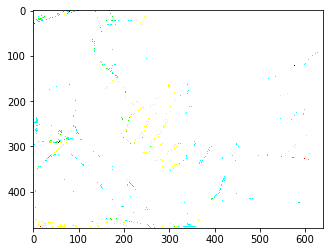

In [295]:
img = cv2.imread("data/imgs/train_aug/c0/img_72495_4.jpg")
img = np.array(img, dtype=np.float32)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
plt.imshow(img)
plt.show()